In [ ]:
# Real scalar boson star or oscillaton example
# see further details in https://github.com/KAClough/BabyGRChombo/wiki/Running-the-oscillaton-example

# restart the kernel to clear past work
# (can also do this manually from the Kernel options above)
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [1]:
# load the required python modules
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import time
import random
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# import homemade code
sys.path.append('../')
from source.rhsevolution import *                             # go here to look at how the evolution works
from source.oscillatoninitialconditions import *              # go here to change the initial conditions
from source.hamdiagnostic import *                            # go here to change the Ham constraint diagnostic

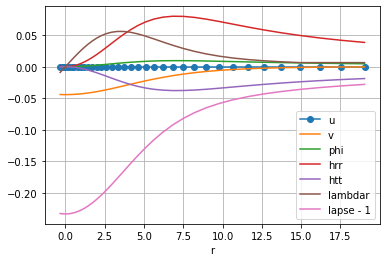

In [2]:
# Input parameters for grid and evolution here
N_r = 30 # num points on physical grid
R = 15.0 # Maximum outer radius

r_is_logarithmic = True
r, initial_state = get_initial_state(R, N_r, r_is_logarithmic)

#unpackage the vector for readability
(initial_u, initial_v , initial_phi, initial_hrr, initial_htt, initial_hpp, 
 initial_K, initial_arr, initial_att, initial_app, 
 initial_lambdar, initial_shiftr, initial_br, initial_lapse) = unpack_state(initial_state, N_r)

#plot initial conditions
plt.xlabel('r')
plt.plot(r, initial_u, '-o', label='u') # zero, but plot as dots to see the grid
plt.plot(r, initial_v, label='v')
plt.plot(r, initial_phi, label='phi')
plt.plot(r, initial_hrr, label='hrr')
plt.plot(r, initial_htt, label='htt')
plt.plot(r, initial_lambdar, label='lambdar')
#plt.plot(r, initial_shiftr, label='shiftr')
plt.plot(r, initial_lapse-1, label='lapse - 1')
plt.legend(loc='best')
plt.grid()
#plt.xlim(-0.25,5.0)
#plt.ylim(-0.0005,0.0005)

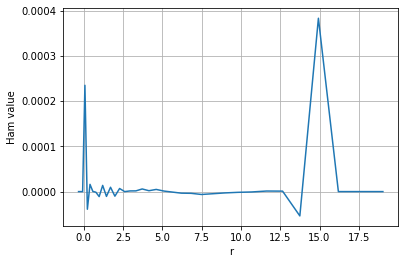

In [3]:
# check the Hamiltonian constraint initially satisfied
# apart from numerical errors
r, Ham = get_Ham_diagnostic(initial_state, np.array([0]), R, N_r, r_is_logarithmic)

# plot the profile for Ham
plt.plot(r, Ham[0])

plt.xlabel('r')
#plt.xlim(-4.0,R+4.0)
#plt.ylim(-0.01,0.01)
plt.ylabel('Ham value')
plt.grid()

In [4]:
# for control of time integrator and spatial grid
T = 16.0 # Maximum evolution time
N_t = 51 # time resolution (only for outputs, not for integration)

# Work out dt and time spacing of outputs
dt = T/N_t
t = np.linspace(0, T-dt, N_t)
eta = 2.0 # the 1+log slicing damping coefficient - of order 1/M_adm of spacetime

# Solve for the solution using RK45 integration of the ODE
# to make like (older) python odeint method use method='LSODA' instead
# use tqdm package to track progress
with tqdm(total=1000, unit="‰") as progress_bar:
    dense_solution = solve_ivp(get_rhs, [0,T], initial_state, 
                               args=(R, N_r, r_is_logarithmic, eta, progress_bar, [0, T/1000]),
                        #atol=1e-5, rtol=1e-5,
                        max_step=(0.1*R/N_r), #for stability and for KO coeff of 10
                        method='RK45', dense_output=True)

# Interpolate the solution at the time points defined in myparams.py
solution = dense_solution.sol(t).T

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [02:26<00:00,  6.83‰/s]


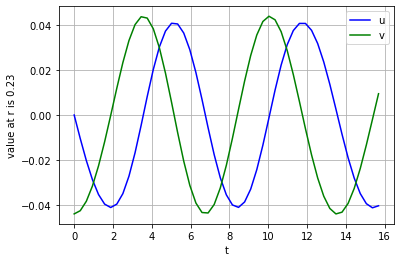

In [5]:
# Plot a single point versus time
var1 = idx_u
var2 = idx_v

idx = num_ghosts+1
r_i = np.round(r[idx],2)
var1_of_t = solution[0:N_t, var1 * (N_r + 2*num_ghosts) + idx]
plt.plot(t, var1_of_t, 'b-', label=variable_names[var1])
var2_of_t = solution[0:N_t, var2 * (N_r + 2*num_ghosts) + idx]
plt.plot(t, var2_of_t, 'g-', label=variable_names[var2])
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('value at r is '+str(r_i))
plt.legend(loc='best')
plt.grid()

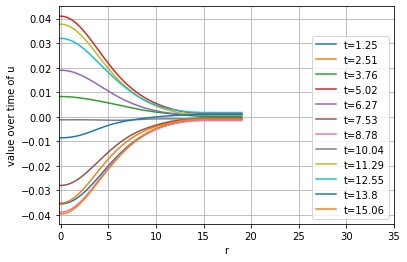

In [6]:
# plot the profile for some variable at a selection of times
var = idx_u # I suggest looking at the field u, or the lapse to see the gauge evolution

for i, t_i in enumerate(t) :
    if (i < N_t) and (i % 4 == 0) and (t_i > 0.0):
        labelt = "t="+str(round(t_i,2))
        f_t = solution[i, var * (N_r + 2*num_ghosts): (var + 1) * (N_r + 2*num_ghosts)]
        plt.plot(r, f_t, label=labelt)

plt.legend(loc=4)
plt.xlabel('r')
plt.xlim(-0.2,35.0)
plt.ylabel('value over time of ' + variable_names[var])
plt.grid()

In [7]:
# calculate the diagnostics, just the Hamiltonian constraint for now
r, Ham = get_Ham_diagnostic(solution, t, R, N_r, r_is_logarithmic)

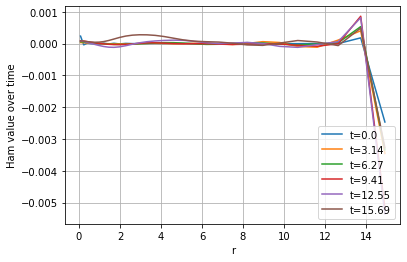

In [8]:
# plot the profile for Ham at a selection of times

for i, t_i in enumerate(t) :
    if (i < N_t) and (i % 10 == 0) :
        labelt = "t="+str(round(t_i,2))
        Ham_t = Ham[i]
        Ham_t = Ham_t[num_ghosts:(N_r + num_ghosts)] # don't plot ghosts for diagnostics
        r_diagnostics = r[num_ghosts:(N_r + num_ghosts)]
        plt.plot(r_diagnostics, Ham_t, label=labelt)

plt.legend(loc=4)
plt.xlabel('r')
#plt.xlim(-1,R+2)
#plt.ylim(-1.0,1.0)
plt.ylabel('Ham value over time')
plt.grid()

In [9]:
solution.shape

(51, 504)

In [10]:
solution[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -4.40183402e-02, -4.41047688e-02, -4.41529646e-02, -4.41529646e-02,
       -4.40930980e-02, -4.39598940e-02, -4.37382026e-02, -4.34109738e-02,
       -4.29594708e-02, -4.23635370e-02, -4.16021535e-02, -4.06541373e-02,
       -3.94995018e-02, -3.81208150e-02, -3.65054494e-02, -3.46478109e-02,
       -3.25520341e-02, -

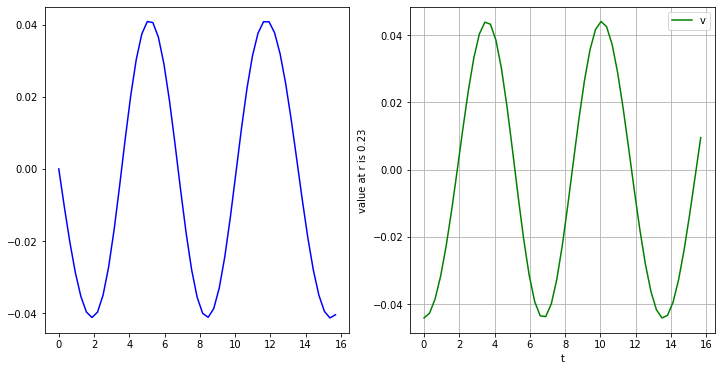

In [11]:
# Plot a single point versus time
var1 = idx_u
var2 = idx_v

idx = num_ghosts+1
r_i = np.round(r[idx],2)
fig, axes = plt.subplots(1,2,figsize=(12,6))
var1_of_t = solution[0:N_t, var1 * (N_r + 2*num_ghosts) + idx]
axes[0].plot(t, var1_of_t, 'b-', label=variable_names[var1])
var2_of_t = solution[0:N_t, var2 * (N_r + 2*num_ghosts) + idx]
axes[1].plot(t, var2_of_t, 'g-', label=variable_names[var2])

plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('value at r is '+str(r_i))
plt.legend(loc='best')
plt.grid()

In [12]:
var1_of_t

array([ 0.        , -0.01049745, -0.02031555, -0.02881862, -0.0354445 ,
       -0.03971599, -0.04124331, -0.03973698, -0.03505294, -0.02728048,
       -0.01685206, -0.00461232,  0.00823302,  0.02031439,  0.03036447,
        0.03742346,  0.04091119,  0.04059707,  0.03654825,  0.02911212,
        0.01893238,  0.00695073, -0.00566251, -0.01766401, -0.02792838,
       -0.03559163, -0.04009883, -0.04117328, -0.03876503, -0.03303081,
       -0.02436281, -0.01343939, -0.00123584,  0.01106486,  0.02226249,
        0.03135187,  0.03765523,  0.0408347 ,  0.04082451,  0.03775218,
        0.03189413,  0.02367317,  0.013675  ,  0.00264684, -0.0085522 ,
       -0.01904984, -0.02807376, -0.03503148, -0.0395327 , -0.04136688,
       -0.04046982])

In [13]:
idx_u

0

In [14]:
N_r

30

In [15]:
var1_of_t_all.shape

NameError: name 'var1_of_t_all' is not defined

In [ ]:
var1_of_t_all = solution[:, idx_u * (N_r + 2*num_ghosts):idx_u * (N_r + 2*num_ghosts) + 30]
plt.ylim((np.min(var1_of_t_all[15]), np.max(var1_of_t_all[15])))
plt.plot(r[num_ghosts:-num_ghosts],var1_of_t_all[15])
plt.show()

In [ ]:
from matplotlib import animation

var1 = idx_u
var2 = idx_v

idx = num_ghosts+1
#r_i = np.round(r[idx],2)
#fig, axes = plt.subplots(1,2,figsize=(12,6))
var1_of_t_all = solution[:, idx_u * (N_r + 2*num_ghosts):idx_u * (N_r + 2*num_ghosts) + 30]


# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(r[0], r[-1]), ylim=(np.min(var1_of_t_all), np.max(var1_of_t_all)))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = r[num_ghosts:-num_ghosts]
    y = var1_of_t_all[i]
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, 
                               frames=np.arange(0,51,1), interval=1, blit=True)
#anim.save('../../../../Desktop/basic_animation.mp4', fps=6, extra_args=['-vcodec', 'libx264'])

plt.show()

In [ ]:
r_t = r_trimmed[1:]
x = y = np.zeros_like(r_t)
for r_coord, i in zip(r_t, range(len(r_t))):
    x[i] = y[i] = r_coord/np.sqrt(2)

var1_interpd = np.zeros((len(r_t),len(r_t)))
for i in range(len(r_t)):
    for j in range(len(r_t)):
        var1_interpd[i][j] = interper1d(x[i],y[j])

In [ ]:
interper = interp1d(r_trimmed,var1_of_t_all[15])
def interper1d(x,y):
    r_interp = np.sqrt(x**2+y**2)
    return interper(r_interp)

In [ ]:
#help(interp2d)
plt.imshow(var1_interpd)

In [ ]:
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig) 
r_trimmed = r[num_ghosts:-num_ghosts]
ax.plot_surface(x,y,var1_interpd)
plt.show()

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
#ax = plt.axes(xlim=(r[0], r[-1]), ylim=(np.min(var1_of_t_all), np.max(var1_of_t_all)))

def interper1d(x,y):
    r_interp = np.sqrt(x**2+y**2)
    return interper(r_interp)

# animation function.  This is called sequentially
def animate(n):
    interper = interp1d(r_trimmed,var1_of_t_all[n])
    var1_interpd = np.zeros((len(r_t),len(r_t)))
    for i in range(len(r_t)):
        for j in range(len(r_t)):
            var1_interpd[i][j] = interper1d(x[i],y[j])
    return plt.imshow(var1_interpd),

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, 
                               frames=np.arange(0,51,1), interval=1, blit=True)
anim.save('../../../../Desktop/2d_animation.mp4', fps=6, extra_args=['-vcodec', 'libx264'])

plt.show()